# <center> Housing Price Prediction with Linear Regression </center>

# Overview:


- #### **The Data**
    - This datasets contains features for ~ 23k houses in Kings County in Seattle, Washington
    - These features include sale price, number of bed/bathrooms, living/lot square footage, condition/grade, age, and location
- #### **The Goal**
    - The end goal is to predict the sale price of a home given the other features using Linear Regression
    - The focus of this project will not be on advanced modelling techniques nor hyperparameter tuning, but instead on....
        - Handling NaNs, Duplicates, Dtypes
        - Data Cleaning
        - Exploratory Data Analysis
        - Feature Engineering
        - Understanding the output of the linear regression model for decision making

# Notebook Outline

- #### **Part 1: Cleaning and EDA**
    - Handle duplicates, NaN's, dtypes, and minimal feature engineering
    - Each feature's distribution is viewed as its relationship with our dependent variable
- #### **Part 2: Feature Engineering and EDA:**
    - Create new features from the original features
    - View distributions and relationship with dependent variable
- #### **Part 3: Modelling and Evaluation**
    - Determine which model was the most successful in prediction
    - Determine which methods were most impactful on model performance (feature engineering vs transforming etc)

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# <center><u> Part 1: Data Cleaning </u></center>

### Import Packages

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import branca.colormap as cm
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
warnings.simplefilter(action='ignore')
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Define custom functions

In [2]:
def hist_box(data, xlabel = None, title = None, font_scale=2, figsize=(9,8), bins = None, x_lim = []):
    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    sns.boxplot(data, ax=ax_box2)
    sns.distplot(data, ax=ax_hist2, bins=bins) if bins else sns.distplot(data, ax=ax_hist2)
    ax_hist2.ticklabel_format(useOffset=False, style='plain')
    if x_lim != []:
        ax_hist2.set_xlim(x_lim[0],x_lim[1])
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()

### Import Data and Inspect

In [3]:
# Import .csv file into DataFrame
df = pd.read_csv(r'kc_house_data.csv')

# Rename columns and index for interpretability
new_names = {'id':'sale_id','date':'sale_date','price':'sale_price','view':'has_been_viewed','sqft_above':'sqft_no_basement',
             'sqft_living15':'sqft_living_15_nn','sqft_lot15':'sqft_lot_15_nn'}

df.rename(columns = new_names, inplace=True)
df.index.name = 'unique_id'

# View sample of DataFrame
display(df.shape)
df.sample(2)

(21597, 21)

,sale_id,sale_date,sale_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,has_been_viewed,condition,grade,sqft_no_basement,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living_15_nn,sqft_lot_15_nn
unique_id,,,,,,,,,,,,,,,,,,,,,
287,6647200060,2/9/2015,405000.0000,3,1.7500,1670,6720,1.0000,NaN,0.0000,3,7,1140,530.0,1980,NaN,98034,47.7198,-122.1930,1670,7320
5128,7852090280,2/19/2015,770000.0000,4,3.2500,4270,6384,2.0000,0.0000,0.0000,3,9,3060,1210.0,2001,NaN,98065,47.5362,-121.8740,2850,6285


# <center> ----------------------------------------------------------------------------------------------------------- </center>

# Duplicates and Missing Data

## Duplicates
- The `sale_id` column does have duplicates, but they appear to be unique sales for the same house

In [4]:
df['sale_id'].duplicated().value_counts()

False    21420
True       177
Name: sale_id, dtype: int64

In [5]:
df.duplicated().value_counts()

False    21597
dtype: int64

## Missing Data

In [6]:
df_nans = pd.DataFrame()
df_nans['Count'] = df.isna().sum()
df_nans['Percent'] = round(df.isna().mean()*100,1)
df_nans[df_nans['Count'] > 0]

,Count,Percent
waterfront,2376,11.0000
has_been_viewed,63,0.3000
yr_renovated,3842,17.8000


### The following columns are missing data
- **`waterfront`** : Missing 2376 values **(11%)**
    - This could be fixed by looking at a map view
    - On average ~ 0.05% of houses are waterfront, so that would mean hand picking only ~12 houses, the rest can be labeled 0
- **`has_been_viewed`** : Missing 63 values **(<1%)**
    - This is such a small subset its likely okay to just drop
- **`yr_renovated`** : Missing 3842 values **(17%)**
    - 96% of homes have not been renovated, so filling with 0 is likely appropriate
    - Might be a good idea testing model with it filled with 0 vs dropped
- **`sqft_basement`** : Has 454 value set to "?" **(2%)** and is the wrong dtype
    - Most houses have no basement, likely okay to fill with 0

#### Waterfront Map
- Plot houses missing `waterfront` data

In [7]:
# Get hand picked list
actually_waterfront = [3577000116,1568100920,2726049034,3761700053,825059178,7129303070,2579500110,1724069060,9201300020,573000685]

# Use list to fill with 1s, then fill the rest with 0s
df.loc[df['sale_id'].isin(actually_waterfront), 'waterfront'] = 1
df['waterfront'] = df['waterfront'].fillna(0)

In [8]:
# Fill with 0s
df['yr_renovated'] = df['yr_renovated'].fillna(0)

In [10]:
# Replace "?" with nan
df['sqft_basement'].replace("?", np.nan, inplace = True)

df['sqft_basement'] = df['sqft_basement'].astype(float)

# Drop NaNs
df = df.dropna()

# <center> ----------------------------------------------------------------------------------------------------------- </center>

# Data Cleaning & EDA

## 1) Sale Price: 
- Target/Dependent Variable
- String Positive Skew
- Likely need to transform

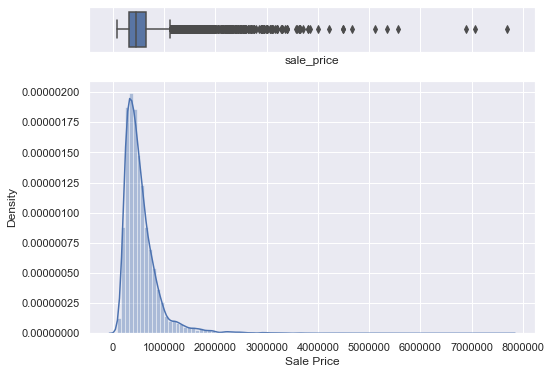

In [11]:
hist_box(df['sale_price'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="Sale Price", 
         #x_lim= [-100000,8000000]
        )

## 2) Sale Date: 
- Cast to proper data type
- Extract year/month

In [12]:
# Convert to dt
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Get month & year together
df['sale_date_trim'] = df['sale_date'].dt.to_period('M')

# Get year
df['sale_year'] = df['sale_date'].dt.year

# Get month
df['sale_month'] = df['sale_date'].dt.month

- View stats by month

In [13]:
date_df = pd.DataFrame()
date_df['num_sales'] = df.groupby('sale_date_trim')['sale_id'].count()
date_df['mean_sale_price'] = df.groupby('sale_date_trim')['sale_price'].mean().astype(int)
date_df['n_days'] = df.groupby('sale_date_trim')['sale_date'].nunique()
date_df

,num_sales,mean_sale_price,n_days
sale_date_trim,,,
2014-05,1724,545803,30
2014-06,2126,558882,30
2014-07,2163,544584,31
2014-08,1894,536062,31
2014-09,1717,528538,30
2014-10,1831,539036,31
2014-11,1375,523796,29
2014-12,1442,525191,29
2015-01,947,526844,26


- There appears to be a strong linear relationship between the number of houses sold in a month and the mean sale price
    - There is one outlier (2015-05), however this month has incomplete data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


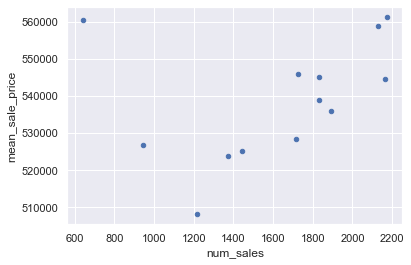

In [14]:
date_df.plot.scatter(x='num_sales',y='mean_sale_price');

- There appears to be a trend in sale price by month
    - Peak = summer/fall
    - Trough = winter/spring

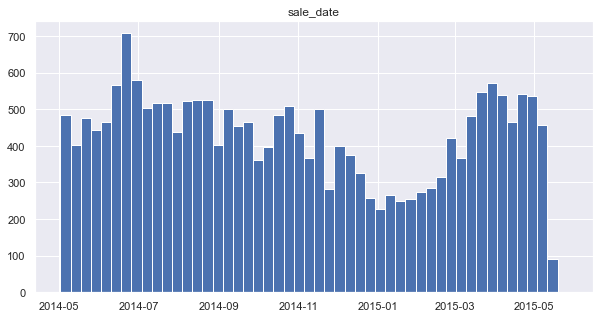

In [15]:
df.hist('sale_date', bins=50, figsize = (10,5));

## 3) Bedrooms: 
- One outlier with 30+ bedrooms (dropped)

In [16]:
df = df[df['bedrooms'] < 15]

- Most homes have between 2 and 5 bedrooms

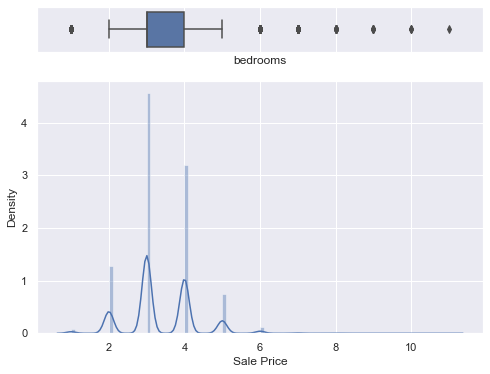

In [17]:
hist_box(df['bedrooms'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="Sale Price", 
         #x_lim= [-100000,8000000]
        )

- There appears to be a linear relationship between bedrooms and sale price
    - This trend weakens after adding more then 5 bedrooms

(-10000.0, 4000000.0)

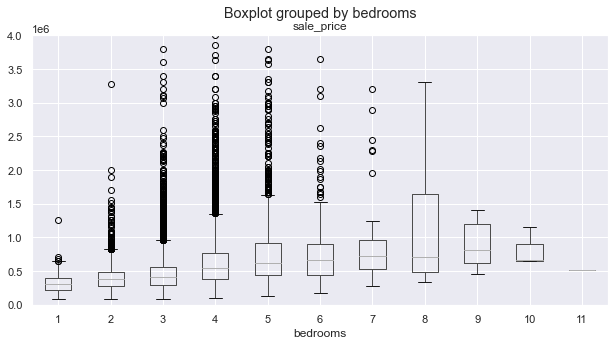

In [18]:
df[['sale_price','bedrooms']].boxplot('sale_price', 
                                      by='bedrooms', 
                                      figsize=(10,5)
                                     ).set_ylim(-10000,4000000)

## 4) Bathrooms: 
- Most houses have between 1 and 3.5 bathrooms

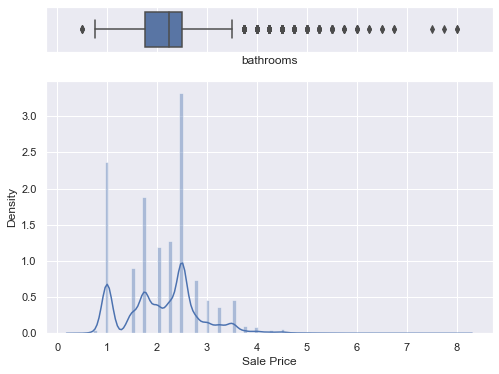

In [19]:
hist_box(df['bathrooms'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="Sale Price", 
         #x_lim= [-100000,8000000]
        )

- There appears to be a strong relationship between bathrooms and sale price
    - The tightness of the trend weakens at higher bathroom counts due to data density, but still exists

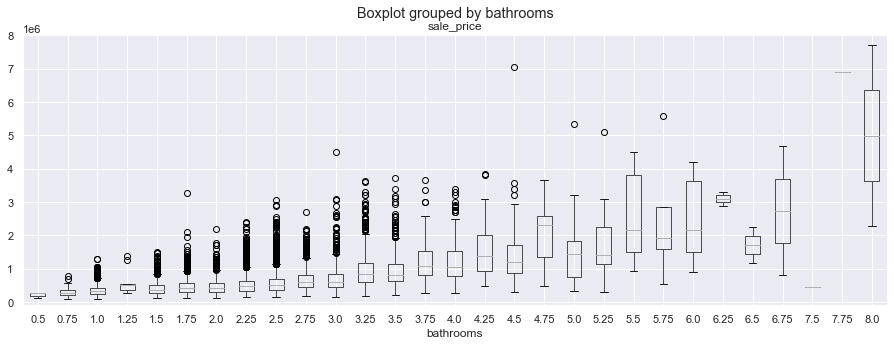

In [20]:
df[['sale_price','bathrooms']].boxplot('sale_price', 
                                      by='bathrooms', 
                                      figsize=(15,5)
                                     ).set_ylim(-100000,8000000);

## 5) Sqft Living: 
- Most houses have between 1 and 3.5 bathrooms
- Positive Skew
- Likely needs a transform for normality

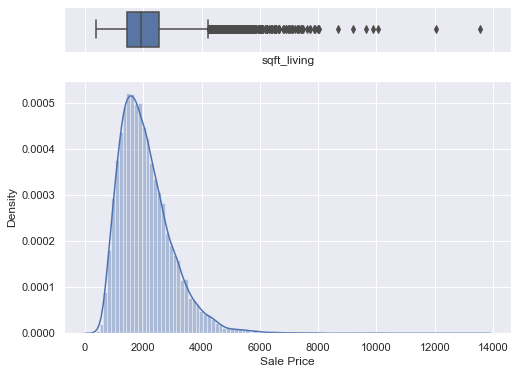

In [21]:
hist_box(df['sqft_living'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="Sale Price" 
        )

- There appears to be a positive relationship between living sqft and sale price
    - The trend is noisy, try boxplot view

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


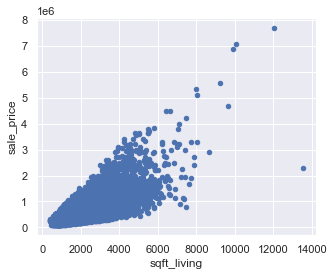

In [22]:
df.plot.scatter(x='sqft_living', y='sale_price', figsize=(5,4));

- This is a more clear view of the relationship

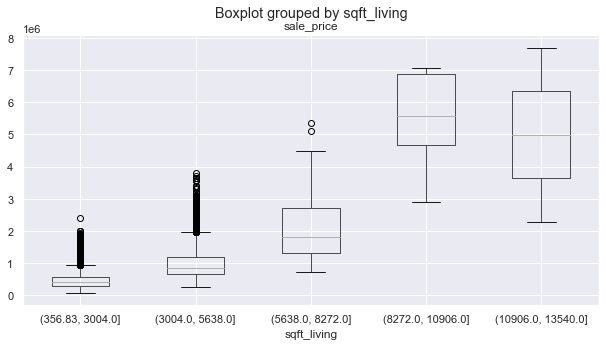

In [23]:
df_temp = df[['sale_price','sqft_living']]
df_temp['sqft_living'] = pd.cut(df['sqft_living'], bins=5)
df_temp[['sale_price','sqft_living']].boxplot('sale_price', 
                                                by='sqft_living', 
                                                figsize=(10,5)
                                                );

## 5) Sqft Lot: 
- Most houses have less thn 25,000 sqft lots, however there are many outliers
- Positive Skew
- Likely needs a transform for normality

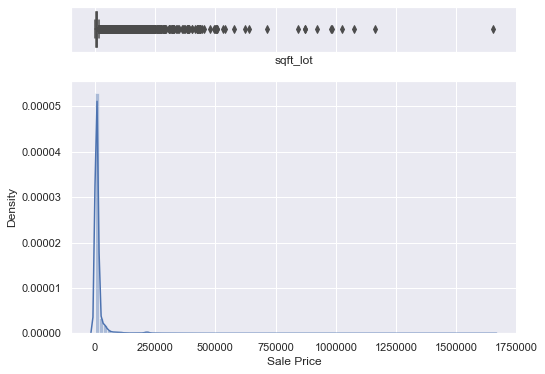

In [24]:
hist_box(df['sqft_lot'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="Sale Price",
         #x_lim= [-100000,100000]
        )

- Sqft Lot has an interesting relationship with sale price
    - Coloring by sqft living highlights how some houses may have a ton of land, but a very small home

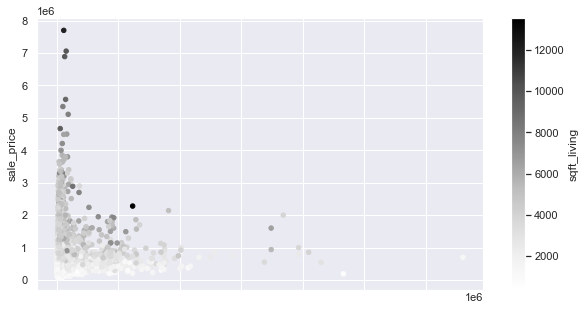

In [25]:
df.plot.scatter(x='sqft_lot', y='sale_price',c='sqft_living', figsize=(10,5));

- This view suggests that we do see a positive relationship as the lot size increases up to about 100,000 sqft

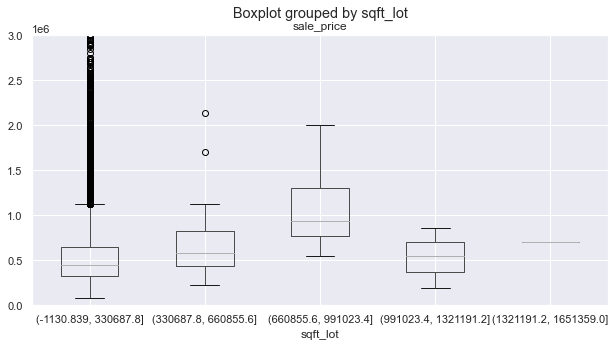

In [26]:
df_temp = df[['sale_price','sqft_lot']]
df_temp['sqft_lot'] = pd.cut(df['sqft_lot'], bins=5)
df_temp[['sale_price','sqft_lot']].boxplot('sale_price', 
                                                by='sqft_lot', 
                                                figsize=(10,5)
                                                ).set_ylim(-1,3000000);

## 6) Floors: 
- Most houses have 1-2 floors

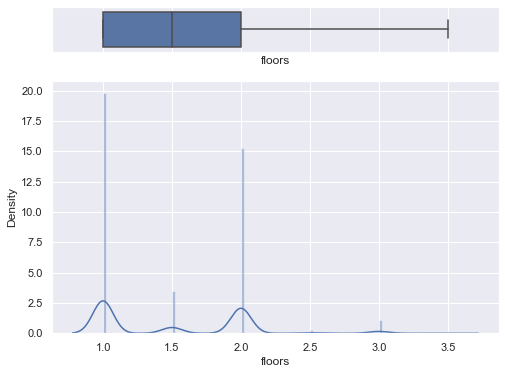

In [27]:
hist_box(df['floors'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="floors",
         #x_lim= [-100000,100000]
        )

- The number of floors has a clear positive relationship with sale price up until 2.5 floors, after which the trend reverses!
    - Quadratic relationship

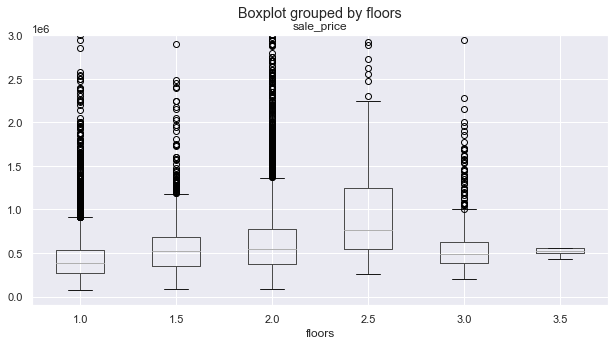

In [28]:
df[['sale_price','floors']].boxplot('sale_price', 
                                      by='floors', 
                                      figsize=(10,5)
                                     ).set_ylim(-100000,3000000);

## 7) Waterfront: 
- Most houses are not waterfront

In [29]:
df['waterfront'].value_counts(normalize=True)

0.0000   0.9928
1.0000   0.0072
Name: waterfront, dtype: float64

- Waterfront houses do appear to have a higher sale price!

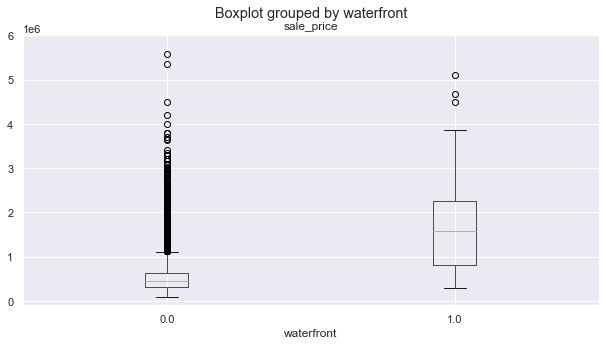

In [30]:
df[['sale_price','waterfront']].boxplot('sale_price', 
                                      by='waterfront', 
                                      figsize=(10,5)
                                     ).set_ylim(-100000,6000000);

## 8) Has Been Viewed: 
- Most houses have not been viewed at all

In [31]:
df['has_been_viewed'].value_counts(normalize=True)

0.0000   0.9021
2.0000   0.0441
3.0000   0.0235
1.0000   0.0155
4.0000   0.0148
Name: has_been_viewed, dtype: float64

- Houses the have been viewed more often time have a higher sale price
- Why?
    - This might hint at quality (higher quality houses will get viewed more)
    - This might also hint at demand (houses with multiple offers will sell for more)

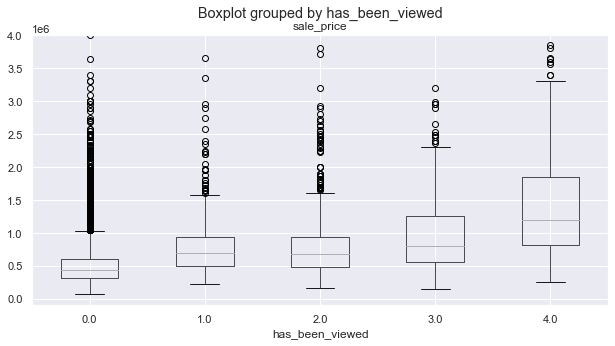

In [32]:
df[['sale_price','has_been_viewed']].boxplot('sale_price', 
                                      by='has_been_viewed', 
                                      figsize=(10,5)
                                     ).set_ylim(-100000,4000000);

## 9) Condition: 
- Most houses have a contition from 2-5
- Strong negative skew

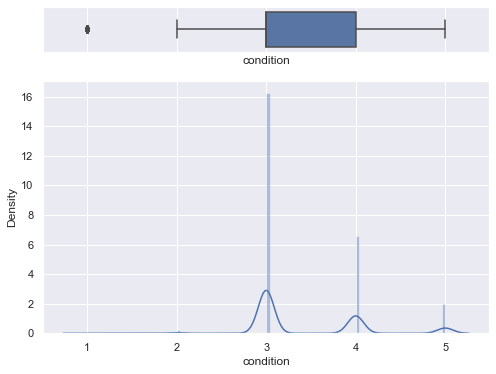

In [33]:
hist_box(df['condition'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         #x_lim= [-100000,100000]
        )

- There appears to be a break here at 3, where houses with condition < 3 have a much lower distribution of sale price than those with >= 3

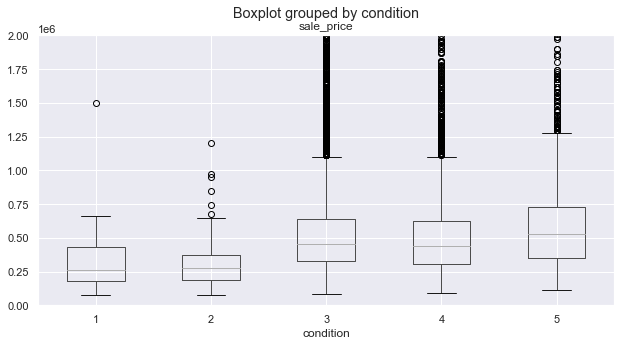

In [34]:
df[['sale_price','condition']].boxplot('sale_price', 
                                      by='condition', 
                                      figsize=(10,5)
                                     ).set_ylim(0,2000000);

## 10) Grade: 
- Most houses have a grade between 6 and 9

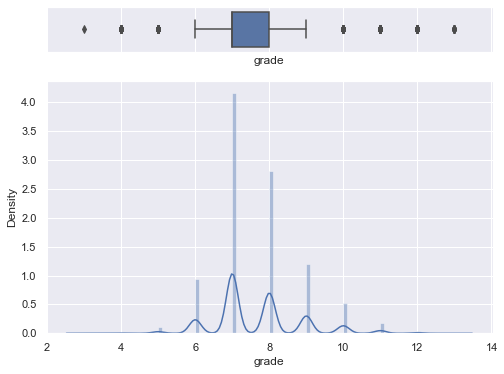

In [35]:
hist_box(df['grade'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         #x_lim= [-100000,100000]
        )

- Grade appears to have a much stronger relationship with sale price than condition did

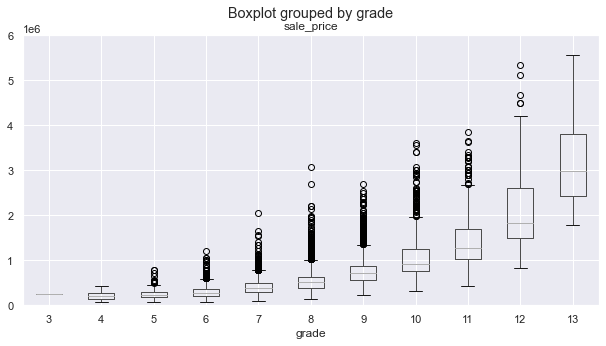

In [36]:
df[['sale_price','grade']].boxplot('sale_price', 
                                      by='grade', 
                                      figsize=(10,5)
                                     ).set_ylim(0,6000000);

## 11) Sqft No Basement: 
- Most houses have less than 4000 sqft excluding their basements
- Positive Skew

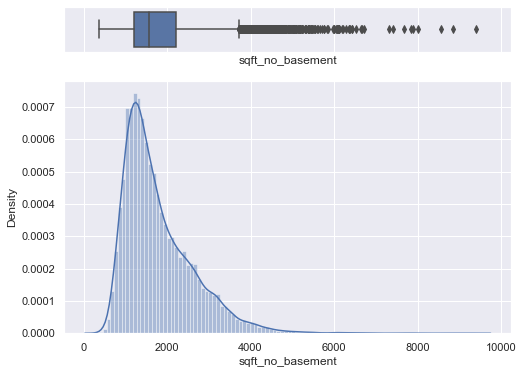

In [37]:
hist_box(df['sqft_no_basement'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         #x_lim= [-100000,100000]
        )

- Strong relationship between sqft_no_basement and sale price

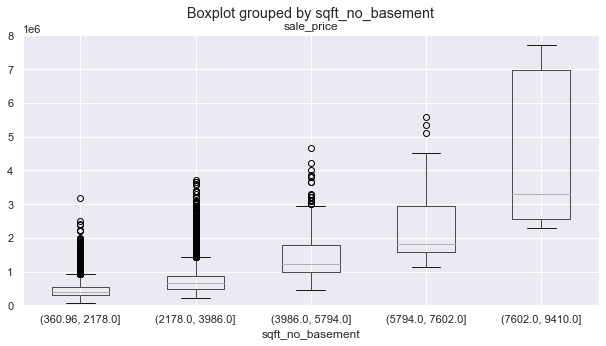

In [48]:
df_temp = df[['sale_price','sqft_no_basement']]
df_temp['sqft_no_basement'] = pd.cut(df['sqft_no_basement'], bins=5)
df_temp[['sale_price','sqft_no_basement']].boxplot('sale_price', 
                                                by='sqft_no_basement', 
                                                figsize=(10,5)
                                                ).set_ylim(-1,8000000);

## 12) Sqft Basement: 
- Most houses don't have a basement

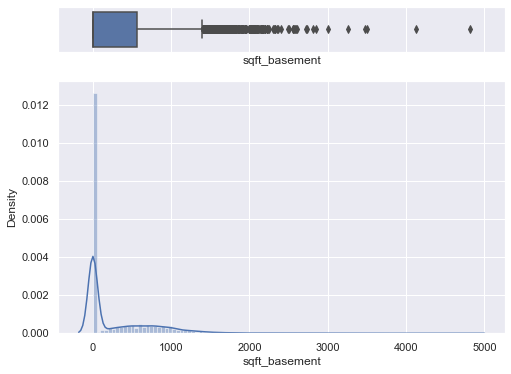

In [40]:
hist_box(df['sqft_basement'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         #x_lim= [-100000,100000]
        )

- Houses with basements on average have higher sale prices

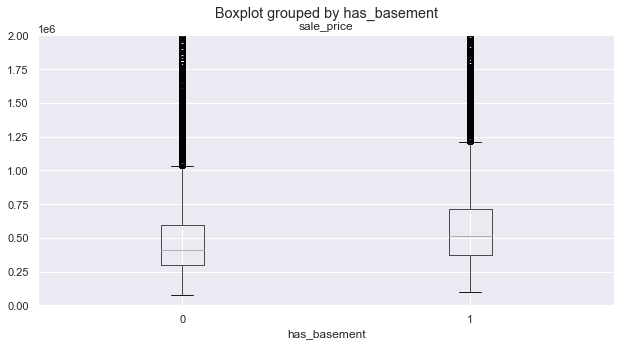

In [45]:
df_temp = df[['sale_price','sqft_basement']]
df_temp['has_basement'] = 0
df_temp.loc[df_temp['sqft_basement'] > 0, 'has_basement'] = 1
df_temp.boxplot('sale_price', 
                by='has_basement', 
                figsize=(10,5)
                ).set_ylim(-1,2000000);

- For houses that have basements, larger basements translate to higher sale prices

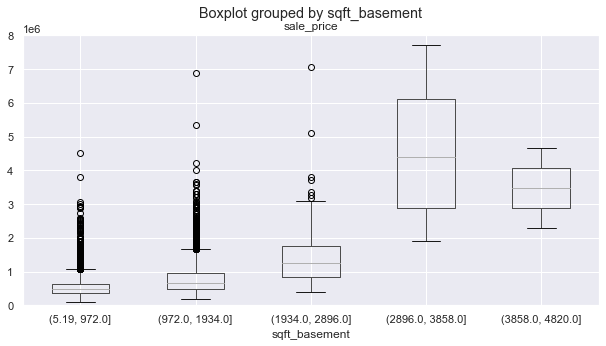

In [47]:
df_temp = df[df['sqft_basement'] > 0][['sale_price','sqft_basement']]
df_temp['sqft_basement'] = pd.cut(df_temp['sqft_basement'], bins=5)
df_temp[['sale_price','sqft_basement']].boxplot('sale_price', 
                                                by='sqft_basement', 
                                                figsize=(10,5)
                                                ).set_ylim(-1,8000000);

## 13) Year Built: 
- Most houses were built between 1960 and 2000

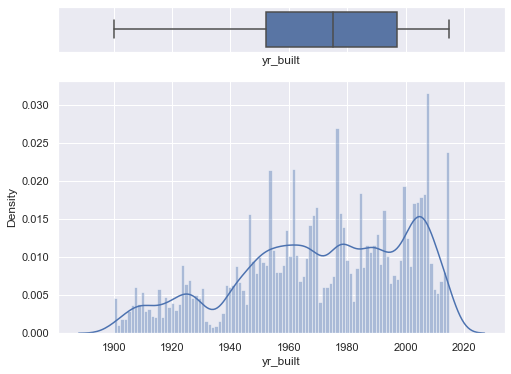

In [49]:
hist_box(df['yr_built'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- Interestingly enough, there is not a strong relationship between the year built and the sale price
- Why?
    - The newer houses being built may have other less favorable characteristics (smaller, lower grade)

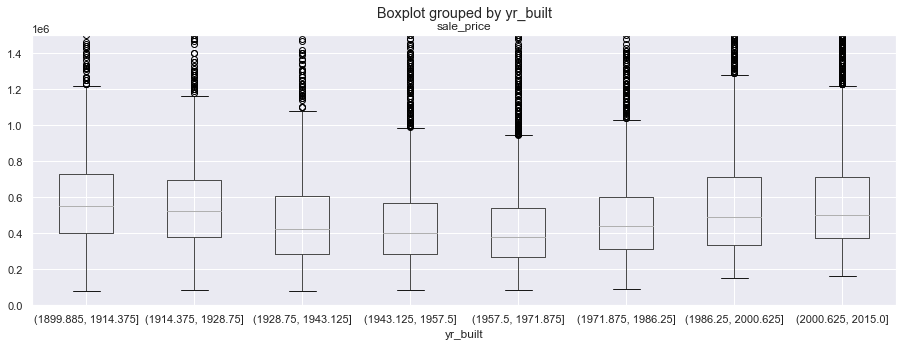

In [55]:
df_temp = df[['sale_price','yr_built']]
df_temp['yr_built'] = pd.cut(df['yr_built'], bins=8)
df_temp[['sale_price','yr_built']].boxplot('sale_price', 
                                            by='yr_built', 
                                            figsize=(15,5)
                                            ).set_ylim(-1,1500000);

## 14) Year Renovated: 
- For homes that were renovated, most were done between 1990 and 2005

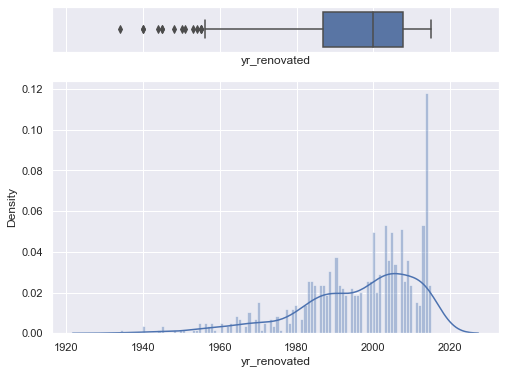

In [57]:
hist_box(df[df['yr_renovated'] > 0]['yr_renovated'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- Houses that were renovated tend to have higher sale prices

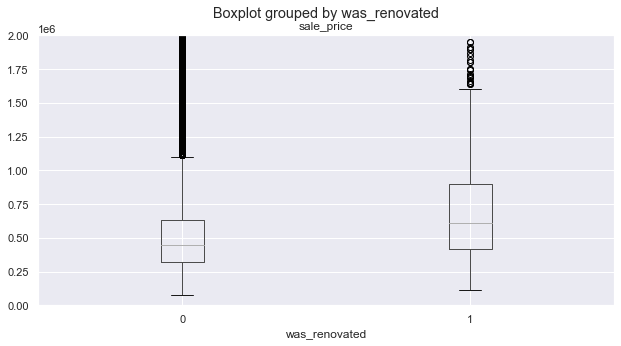

In [59]:
df_temp = df[['sale_price','yr_renovated']]
df_temp['was_renovated'] = 0
df_temp.loc[df_temp['yr_renovated'] > 0, 'was_renovated'] = 1
df_temp.boxplot('sale_price', 
                by='was_renovated', 
                figsize=(10,5)
                ).set_ylim(-1,2000000);

- For houses that were renovated, those that were worked on more recently tended to have higher sale prices

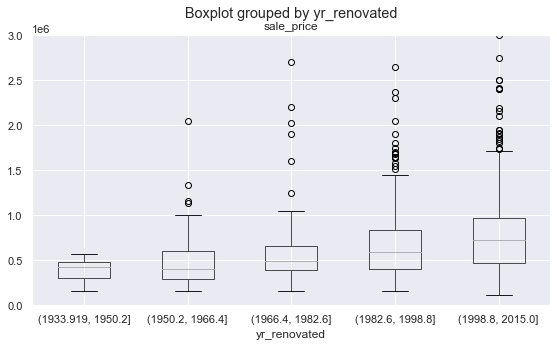

In [63]:
df_temp = df[df['yr_renovated'] > 0][['sale_price','yr_renovated']]
df_temp['yr_renovated'] = pd.cut(df_temp['yr_renovated'], bins=5)
df_temp[['sale_price','yr_renovated']].boxplot('sale_price', 
                                                by='yr_renovated', 
                                                figsize=(9,5)
                                                ).set_ylim(-1,3000000);

In [39]:
df.columns.tolist()

['sale_id',
 'sale_date',
 'sale_price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'has_been_viewed',
 'condition',
 'grade',
 'sqft_no_basement',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living_15_nn',
 'sqft_lot_15_nn',
 'sale_date_trim',
 'sale_year',
 'sale_month']

## 15) Zipcode: 
- For homes that were renovated, most were done between 1990 and 2005

In [99]:
df['zipcode'].nunique()

70

In [122]:
zip_df = pd.DataFrame()
zip_df['num_houses'] = df.groupby('zipcode')['sale_id'].count()
zip_df['mean_sale_price'] = df.groupby('zipcode')['sale_price'].mean().astype(int)
zip_df = zip_df.sort_values('mean_sale_price', ascending=False)
zips_to_include = zip_df.index.tolist()[::7]
zip_df = zip_df[zip_df.index.isin(zips_to_include)]
zip_df

,num_houses,mean_sale_price
zipcode,,
98039,49,2135612
98119,176,861480
98077,196,681461
98115,565,619752
98024,78,575508
98011,191,490331
98019,188,425467
98038,571,366476
98042,540,311786


### Thoughts on Features:
- **`sale_date`** 
    - Convert to Pandas Datetime object
    - Distribution shows trend (less home sales in 2015)
        - Feature Engineer 
- **`sale_price`** 
    - Logarithmic, outliers
- **`bedrooms`** 
    - Logarithmic, one outlier
    - Non-linear relationship with sales_price
- **`bathrooms`** 
    - Few outliers
    - Positive correlation with sales_price on high end (probably worth keeping)
- **`sqft_living`** 
    - Logarithmic, outliers
    - Strong correlation with sales_price except for last data point
- **`sqft_lot`** 
    - Logarithmic, tons of outliers
- **`floors`**
    - OK
- **`has_been_viewed`**
    - OK
- **`condition`**
    - OK
- **`grade`**
    - OK
    - Strong correlation with sales price
- **`sqft_no_basement`** :
    - Logarithmic, outliers
- **`sqft_basement`**
    - Convert to float
    - Logarithmic, outliers
- **`yr_built`** 
    - OK
- **`yr_renovated`** 
    - Many zero values, may need to bump
    - Feature engineer binary?
    - Logarithmic
- **`zipcode`** 
    - Need to make categorical
    - Feature engineer
        - Calculate metrics by zip code
- **`lat/long`** 
    - Possible feature engineer
- **`sqft_living_15_nn`** 
    - Logarithmic, outliers
- **`sqft_lot_15_nn`** 
    - Logarithmic, outliers

### Typecast and engineer **`sqft_basement`**

In [ ]:
# Typecast to float
df['sqft_basement'] = df['sqft_basement'].astype(float)

# Create new column and assign zero
df['has_basement'] = 0

# Denote all houses that have a sqft_basement > 0 as having a basement
df.loc[df['sqft_basement'] > 1,'has_basement'] = 1

# Drop old feature
df = df.drop(columns=['sqft_basement','sqft_no_basement'])

### Manipulate **`yr_renovated`**

In [ ]:
# Create new column and assign zero
df['is_renovated'] = 0

# Denote all houses that have a renovation date as renovated
df.loc[df['yr_renovated'] > 1,'is_renovated'] = 1

# Drop old feature
df = df.drop(columns=['yr_renovated'])
df.sample(2)

# Declare cleaned DataFrame for EDA

In [ ]:
# Drop unwanted columns
df_cleaned = df.loc[:,~df.columns.str.contains('sale_date|sale_id')]
df_cleaned.sample()

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# <center><u> Part 2: Questions </u></center>

## Question #1: Does the housing market have a seasonal trend in sale volume?

In [ ]:
# Create figure
fig = px.histogram(df, 
                   x="sale_date", width=1000, height=400,
             title = "Number of Houses Sold Over Time",
             labels = {'sale_date':'Date of Sale'
                     })
fig.show()

### Interpretation:
- There does appear to be a trend in volume of houses sold through time
    - There is a gradual decline from July through January, then a recovery through May
    - Possible Interpretation: More homes may sell in the summer than in the winter, may also be macro-economic driven (need more data)
- It might be worth trying to feature engineer month and year from our data
    - These trends might hint at the supply/demand dynamic that can cause homes to sell above/below market value

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

## Question #2: Is there any one feature on a map that appears to drive prices higher?

In [ ]:
# Create map
map_visual = folium.Map(location=(df['lat'].mean(), df['long'].mean()), zoom_star = 9, width = 500, height = 500)

# Specify feature to color by
color_by = 'sale_price'

# Create color map
colormap = cm.LinearColormap(colors=['black','gray','green','yellow','orange','red'], vmin=200000, vmax= 1250000)

# Loop through each home in set, create circle, add to map.
for idx in df_cleaned.index:
    folium.Circle(
        location=[df_cleaned.loc[idx]['lat'], df_cleaned.loc[idx]['long']],
        radius = 8,
        fill = True,
        color = colormap(df_cleaned.loc[idx][color_by]),
        fill_opacity = 0.2
    ).add_to(map_visual)
    
# Add colorbar
colormap.caption = 'Sale Price'
map_visual.add_child(colormap)

# View
map_visual

### Interpretation:
- Houses that are closer to the two primary lakes (Washington and Sammamish) tend to have higher prices
- There are high value homes that lie away from these areas, but they are a minority

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

## Question #3: Do any of our variables show a non-linear relationship with **`sales_price`**?

In [ ]:
# Create Plot
fig = px.box(x=df['floors'],
             y=df['sale_price'],
             points = 'all',
             title = "Number of Floors vs. Sales Price",
             labels = {'x':'Number of Floors',
                     "y": "Sales Price ($MM)"
                     },
            height = 550,
            width = 800)

# Set y-limit
fig.update_layout(yaxis_range=[0,2750000])

fig.show()

### Interpretation:
- The amount of floors the home has appears to have an almost quadratic relationship with sales price
- It appears people value homes with 2-2.5 floors the most, adding additional floors beyond this threshold translates to *lower* prices
- Further Questions: Would our model perform better by dropping this varaible, or by removing data points with > 2.5 floors?

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# <center><u> Part 3: Modelling </u></center>

## Define Function to feature engineer with **`zipcode`**
- This function does the following:
    - Creates a test/train split
    - Conditional upon an argument, it will perform feature engineering
        - A summary statistic is calculated for features grouped by zipcodes ***from the training data*** to prevent data leakage
    - It returns a DataFrame, and the train/test splits. The indexes of these splits are then used to define our splits for the final model

In [ ]:
def feature_engineer(dataframe, engineer = 1):
    ''' 
    - Accepts a DataFrame object and a boolean value.
        - If the boolean value is 1:
            The function will create a train/test split, then perform feature engineering by calculating new features grouped by zipcode
        - If the boolean value is 0:
            The funciton will create a train/test split, it will not perform any feature engineering
    - Returns a DataFrame, and the train/test splits for the X and y
    '''
    
    if engineer == 1:
        
        # Create our X and y
        y0 = dataframe['sale_price']
        X0 = dataframe.drop(columns=['sale_price'])
        
        # Train/Test Split
        X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size = 0.25, random_state = 42)

        # Create DataFrame of training data only
        train_data0 = pd.merge(X_train0, y_train0, left_index = True , right_index = True)

        # Create DataFrame to populate with GroupBy data
        zipcode_dataframe = pd.DataFrame()

        # Create a column in the new DataFrame for each feature grouped by zipcode
        # We are adding data to our primary DataFrame "dataframe", but only extracting data from our train set
        for col in ['sale_price','sqft_living','grade','yr_built','sqft_lot','condition','has_been_viewed','bedrooms','waterfront']:                
            zipcode_dataframe[f'median_{col}_in_zip'] = train_data0.groupby('zipcode')[col].median()

        # Add column to original DataFrame
        dataframe = dataframe.merge(zipcode_dataframe, left_on = 'zipcode', right_index = True)
                        
        return dataframe, X_train0, X_test0, y_train0, y_test0 
    
    else:
        
        # Perform same steps as above, omitting the feature engineering
        y0 = dataframe['sale_price']
        X0 = dataframe.drop(columns=['sale_price'])
        X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size = 0.25, random_state = 42)

        train_data0 = pd.merge(X_train0, y_train0, left_index = True , right_index = True)

        return dataframe, X_train0, X_test0, y_train0, y_test0 

## Modelling
- Define function to test/train split and build linear regression model for a given DataFrame

In [ ]:
def split_and_model(dataframe, X_train0, X_test0, y_train0, y_test0):
    ''' 
    - Accepts a DataFrame as well as train/test splits passed from a previously defined feature_engineering function:
    - This function defines the dependent variable, recreates train/test splits using the indexes of the provided splits,
      tests to ensure that they are the same, then creates a linear regression model from the data.
    - Returns a R-Squared, Adjusted R-Squared, and a dictionary with the features and coefficients
    '''
    # Define our dependent variable based on the provided columns in our DataFrame
    # Due to the iterative nature of the model building, sometimes our dependent varible will be log-transformed, sometimes not
    dep_var = 'sale_price' if 'sale_price_log' not in dataframe.columns else 'sale_price_log'
            
    # Define X and y
    y = dataframe[dep_var]
    X = dataframe.drop(columns=[dep_var])
    
    # Create splits using the indexes from the previously defined splits to ensure they are identical
    X_train = dataframe[dataframe.index.isin(X_train0.index)].drop(columns=[dep_var])
    X_test = dataframe[dataframe.index.isin(X_test0.index)].drop(columns=[dep_var])
    y_train = dataframe[dataframe.index.isin(y_train0.index)][dep_var]
    y_test = dataframe[dataframe.index.isin(y_test0.index)][dep_var]

    # Test to ensure that our splits are the same as before
    test1 = set(X_train.index) == set(X_train0.index)
    test2 = set(X_test.index) == set(X_test0.index)
    test3 = set(y_train.index) == set(y_train0.index)
    test4 = set(y_test.index) == set(y_test0.index)

    if np.all([test1, test2, test3, test4]):
        
        # Create linear model
        reg = LinearRegression().fit(X_train, y_train)

        # Evaluate Model
        # Calculate R-Squared
        R2 = round(reg.score(X_test, y_test), 3)

        # Calculate Adjusted R-Squared
        p = len(X.columns)
        n = len(X)
        adj_r2 = round(1-(1-R2)*(n-1)/(n-p-1),3)

        # Create dictionary of features and their coefficients
        results_dict = {X.columns[i]: abs(reg.coef_[i]) for i in range(len(X.columns))}
        results_dict = dict(sorted(results_dict.items(), key=lambda item: item[1], reverse=True))

        return R2, adj_r2, results_dict, reg
    
    else:
        print('ERROR WITH TRAIN TEST SPLIT')

## Log Transform Values
- Define a function to log transform a list of provided columns, then drop the non-transformed columns

In [ ]:
def log_transform_and_drop(dataframe):
    ''' 
    - Accepts a DataFrame 
    - Log transforms predetermined columns in the DataFrame
    - Drop the columns that have transformed versions from the DataFrame
    - Returns the new DataFrame with transformed columns
    '''
    
    for col in ['sale_price','bedrooms','sqft_living','sqft_lot','condition','sqft_living_15_nn','sqft_lot_15_nn']:
        dataframe[f'{col}_log'] = np.log10(dataframe[col])
        
    dataframe = dataframe.drop(columns=[i for i in dataframe.columns if str(i) + '_log' in dataframe.columns])
    
    return dataframe

## Feature Scaling
- Define function to scale our features

In [ ]:
def scale_features(dataframe):
    ''' 
    - Accepts a DataFrame 
    - Scales all of the data in the DataFrame using StandardScaler()
    - Returns the new DataFrame
    '''
    # Create Scalar
    scaler = StandardScaler()

    # Fit and transform the data, creating DataFrame with same index/columns as the original
    scaled_dataframe = pd.DataFrame(scaler.fit_transform(dataframe), index = dataframe.index, columns = dataframe.columns)
  
    return scaled_dataframe

## Iterate

In [ ]:
# Create DataFrame to hold results
results_df = pd.DataFrame()

# Create variable to keep count of the number of iterations
count = 0

for feature_engineering in [0,1]:

    df_cleaned_engineered, X_train0, X_test0, y_train0, y_test0 = feature_engineer(df_cleaned, feature_engineering)

    for standardized in [0,1]:

        for log in [0,1]:

            df_temp = df_cleaned_engineered.copy()

            if log == 1:
                df_temp = log_transform_and_drop(df_temp)

            if standardized == 1:
                df_temp = scale_features(df_temp)                    

            # Train Test Split
            R2, adj_r2, results_dict, model = split_and_model(df_temp,X_train0, X_test0, y_train0, y_test0)

            # Add results to the results_df
            results_df.loc[count,'Adj_R2'] = adj_r2
            results_df.loc[count,'R2'] = R2
            results_df.loc[count,'Log_Transformed'] = log
            results_df.loc[count,'Standardized'] = standardized
            results_df.loc[count,'features_engineered'] = feature_engineering
            results_df.loc[count,'1st_important_feature'] = list(results_dict.keys())[0]
            results_df.loc[count,'2nd_important_feature'] = list(results_dict.keys())[1]
            results_df.loc[count,'3rd_important_feature'] = list(results_dict.keys())[2]

            count += 1

            if count % 250 == 0:
                print(count)

results_df.sort_values('Adj_R2', ascending = False).head()

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# <center><u> Part 4: Model Evaluation </u></center>

### Does our Log Transform and/or Feature Engineering impact the Accuracy of the model?
- It does appear that both of these workflows had a substantial impact on our models predictions
    - Log Transformation improved performance by **~ 7%**
    - Feature Engineering improved performance by **~ 10%** 

In [ ]:
fig = px.box(results_df,
             x="features_engineered",
             y="Adj_R2",
             title = "Model Performance Across Feature Engineering and Log Transformation",
             color='Log_Transformed', points = 'all',
             height = 500, width = 700)
fig

### Does trimming outliers have a notable impact on our model?
- Trimming the outliers for `lot_size` does have a *marginal* impact on the model results
- As we start to trim the values the performance does creep higher, but the results become significantly less stable
    - The results are more stable for the log-transformed values
    - This leads me to believe these improvements are being driven by noise, not a real relationship
    - A case could be make to trim values at ~350,000 for a ~1% increase

In [ ]:
df_plot = results_df.copy()
df_plot.sort_values(by='max_lot_size', inplace=True)

fig = px.scatter(df_plot, 
             x = 'max_lot_size', 
             y = 'Adj_R2', 
             color='Log_Transformed',
             color_continuous_scale='bluered',
             title = "Model Performance Across Different Max Lot Sizes",
             width = 700,
             height = 500)

fig.update_layout(yaxis_range=[0.65,0.9])

fig.show()

### Scaling

- Scaling does not have an impact on the models accuracy
- It does have a huge impact on the coefficients of the model parameters
- This makes some features appear more/less impactful, and scaling the model is very important for interpretation

### Statsmodels Linear Regression

In [ ]:
from statsmodels.formula.api import ols

# Define DataFrame
final_df = df_cleaned.copy()
# Feature Engineer
final_df, X_train0, X_test0, y_train0, y_test0 = feature_engineer(final_df,1)
# Log Transform
final_df = log_transform_and_drop(final_df)
# Scale
final_df = scale_features(final_df)
# Drop columns with low p-value (iterative)
final_df = final_df.drop(columns=['zipcode','floors'])

# Define dependent / indepenent variables 
outcome = 'sale_price_log'
x_cols = final_df.drop(columns=[outcome]).columns

# String together predictors
predictors = '+'.join(x_cols)

# Define formula
formula = outcome + '~' + predictors

# Create model
model = ols(formula = formula, data = final_df).fit()

# View Results
model.summary()

### Create dictionary to bind features to coefficients and sort

In [ ]:
# Create dictionary with features for keys and coefficients for values
results_dict = {x_cols[i]: model.params[i] for i in range(len(x_cols))}
# Sort dictionary by absolute value of coefficient
results_dict = dict(sorted(results_dict.items(), key=lambda item: abs(item[1]),reverse=True))

### View Feature Importance

In [ ]:
fig = px.bar(x=results_dict.keys(), y=results_dict.values())
fig.show()

### Effect Plot
- Weights multiplied by features

In [ ]:
fig = go.Figure(layout=go.Layout(height=500, width=1000))

for feature, coef in results_dict.items():
    fig.add_trace(
        go.Box(
               y=final_df[feature]*coef,
               name=feature))

fig.show()

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

## Model Explanation

- The model created in this notebook has the ability to predict housing price with ~ 88% accuracy. It has interpreted that while certain properties of the home such as the age, size, and quality are indeed important, the quality and price of homes in the same general location are very important as well. This is intuitive to understand, as nicer homes are likely to be worth less when surrounded by homes that are of a lower quality. It also yields insight into the mentality of the buyer, people don't feel as if they are just purchasing homes, but communities. 

### Coefficient #1: **`median_sqft_living_in_zip`**
- This was interpreted to be the most important feature and appears to have a *positive* impact on the price of a home
- If a house is in a zipcode that doesn't have any extremely small homes, it tends to have a higher value

### Coefficient #2: **`sqft_lot_log`**
- This was interpreted to be the second most important feature and appears to have a *positive* impact on the price of a home
- It is interesting that the lot size of the property is a better predictor of price than the square footage of the house

### Coefficient #3: **`yr_built`**
- This was interpreted to be the third most important feature and appears to have a *positive* impact on the price of a home
- This is intuitive, newer houses appear to be worth more
- When scatterplotting the year built vs sales price there does not appear to be a strong relationship
    - The model was able to untangle the complex relationships and determine that newer houses are priced higher

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# Further Insight: Possible Opporunity
- Here the "best" model is recreated, and houses who appear to be severly undervalued are identified

### Re-create "best" model calculate predictions, actuals, residuals

In [ ]:
df_clean_clip = df_cleaned[df_cleaned['sqft_lot'] < 350000]
df_clean_clip_engineered, X_train0, X_test0, y_train0, y_test0 = feature_engineer(df_clean_clip, 1)
df_temp = log_transform_and_drop(df_clean_clip_engineered)
R2, adj_r2, results_dict, model = split_and_model(df_temp,X_train0, X_test0, y_train0, y_test0)
X = df_temp.drop(columns=['sale_price_log'])
y = df_temp['sale_price_log']
comparison_df = X.copy()
comparison_df['Prediction'] = model.predict(comparison_df)
comparison_df['Actual'] = y
comparison_df['Residual'] = comparison_df['Prediction'] - comparison_df['Actual']

### Plot predictions vs actuals

In [ ]:
fig = px.scatter(comparison_df, 
                 x='Prediction', 
                 y='Actual', 
                 trendline="ols",
                 color='Residual',
                 color_continuous_scale='portland',
                 title='Model Prediction Price vs Actual Price',
                 height = 400,
                 width = 700
                )
fig.show()

### Identify undervalued homes after visual inspection

In [ ]:
df_opportunity = comparison_df[comparison_df['Residual'] > 0.20]
display(df_opportunity.shape)
df_opportunity.head()

### Map Residuals

In [ ]:
import folium
import branca.colormap as cm

# Create map
map_visual = folium.Map(location=(df_opportunity['lat'].mean(), df_opportunity['long'].mean()), zoom_star = 9, width = 500, height = 500)

# Specify feature to color by
color_by = 'Residual'

# Create color map
colormap = cm.LinearColormap(colors=['black','gray','green','yellow','orange','red'], vmin=.15, vmax= .4)

# Loop through each home in set, create circle, add to map.
for idx in df_opportunity.index:
    folium.Circle(
        location=[df_opportunity.loc[idx]['lat'], df_opportunity.loc[idx]['long']],
        radius = 100,
        fill=True,
        color = colormap(df_opportunity.loc[idx][color_by]),
    
    ).add_to(map_visual)
    
# Add colorbar
colormap.caption = 'Sale Price'
map_visual.add_child(colormap)

# View
map_visual